In [1]:
import numpy as np
import scipy.signal as sig
data = np.array([[0, 105, 0], [40, 255, 90], [0, 55, 0]])
G_x = sig.convolve2d(data, np.array([[-1, 0, 1]]), mode='valid')
G_y = sig.convolve2d(data, np.array([[-1], [0], [1]]), mode='valid')

# 1. Load Manu Ginobilli figure & Convolution visualization

In [2]:
import scipy
import scipy.signal as sig
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
# With mode="L", we force the image to be parsed in the grayscale, so it is
# actually unnecessary to convert the photo color beforehand.
img = imageio.imread("manu-2004-Copy1.jpg", as_gray=True)

In [69]:
img.shape

(300, 400)

In [70]:
# Define the Sobel operator kernels.
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = sig.convolve2d(img, kernel_x, mode='same')
G_y = sig.convolve2d(img, kernel_y, mode='same')
print('The shape of G_x is',G_x.shape)
print('The shape of G_y is',G_y.shape)

The shape of G_x is (300, 400)
The shape of G_y is (300, 400)


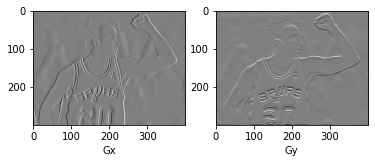

In [71]:
# Plot them!
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Actually plt.imshow() can handle the value scale well even if I don't do
# the transformation (G_x + 255) / 2.
ax1.imshow((G_x + 255) / 2, cmap='gray'); ax1.set_xlabel("Gx")
ax2.imshow((G_y + 255) / 2, cmap='gray'); ax2.set_xlabel("Gy")
plt.show()

# 2. HOG method

In [74]:
from functools import reduce
N_BUCKETS = 9
CELL_SIZE = 8 # Each cell is 8x8 pixels
BLOCK_SIZE = 2 # Each block is 2x2 cells
def assign_bucket_vals(m, d, bucket_vals):
    #print('direction is',d)
    left_bin = int(d / 20.)
    #print('left bin is',left_bin)
    # Handle the case when the direction is between [160, 180)
    right_bin = (int(d / 20.) + 1) % N_BUCKETS
    #print("right_bin is",right_bin)
    #assert 0 <= left_bin < right_bin <= N_BUCKETS
    if right_bin!=0:
        left_val= m * (right_bin * 20 - d) / 20
    elif right_bin==0:
        left_val= m * (180 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val
    
def get_magnitude_hist_cell(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    #directions = np.abs(np.arctan(cell_y / cell_x) * 180 / np.pi)
    directions = np.arctan(cell_y / cell_x) * 180 / np.pi
    for i in range(CELL_SIZE):
        for j in range(CELL_SIZE):
            if directions[i,j]<0:
                directions[i,j]=180+directions[i,j]
                
    print('Magnitude is',magnitudes.shape)
    print('Direction is',directions.shape,'\n')
    buckets = np.linspace(0, 180, N_BUCKETS + 1)
    bucket_vals = np.zeros(N_BUCKETS)
    
    #for i in range(CELL_SIZE):
    #    for j in range(CELL_SIZE):
    #        assign_bucket_vals(magnitudes[i,j],directions[i,j],bucket_vals)
    
#     map(
#         lambda m, d: assign_bucket_vals(m, d, bucket_vals),
#         zip(magnitudes.flatten(), directions.flatten())
#     )
    
    [assign_bucket_vals(m, d, bucket_vals) for m, d in zip(magnitudes.flatten(), directions.flatten())]
    
    #print('bucket_vals are',bucket_vals)
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y):
    # (loc_x, loc_y) defines the lower left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 



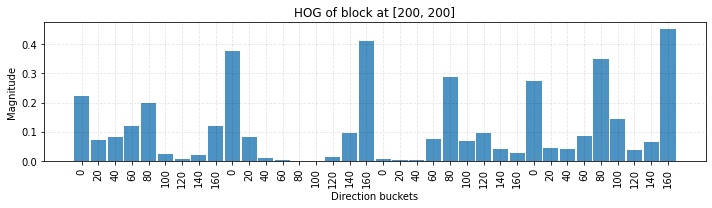

In [75]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200
ydata = get_magnitude_hist_block(loc_x, loc_y)
#print('Temporary ydata is',ydata)
ydata = ydata / np.linalg.norm(ydata)
xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

# Next, let's try a more comprehensive way dealing with the Manu's picture

(300, 400)


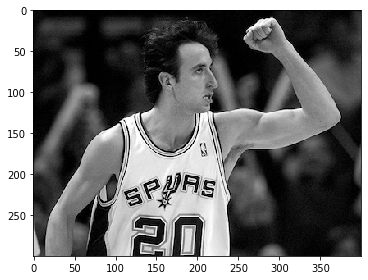

In [42]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline


#reading the image
#img = imread("manu-2004-Copy1.jpg")
img = imread("manu-2004-Copy1.jpg",as_gray=True)
imshow(img)
print(img.shape)

(256, 128)


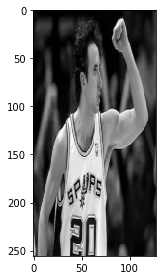

In [43]:
#resizing image 
resized_img = resize(img, (256,128)) 
imshow(resized_img)
print(resized_img.shape)

In [44]:
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

G_x = sig.convolve2d(resized_img, kernel_x, mode='same')
G_y = sig.convolve2d(resized_img, kernel_y, mode='same')
print('The shape of G_x is',G_x.shape)
print('The shape of G_y is',G_y.shape)

The shape of G_x is (256, 128)
The shape of G_y is (256, 128)


In [45]:
# Get magnitude and orientation:
mag=np.sqrt(G_x**2+G_y**2)
tan=G_y/G_x
ori=np.arctan(tan)*(180/np.pi)+90
print(mag.shape)
print(np.max(ori))

(256, 128)
179.96919412079262


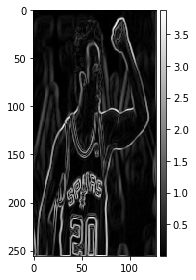

In [47]:
# Visualize the magnitude
imshow(mag,cmap="gray")

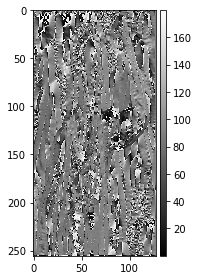

In [48]:
# Visualize the orientation
imshow(ori,cmap="gray")

In [49]:
465*36

16740

In [59]:
from functools import reduce
N_BUCKETS = 9
CELL_SIZE = 8 # Each cell is 8x8 pixels
BLOCK_SIZE = 2 # Each block is 2x2 cells
def assign_bucket_vals(m, d, bucket_vals):
    #print('direction is',d)
    left_bin = int(d / 20.)
    #print('left bin is',left_bin)
    # Handle the case when the direction is between [160, 180)
    right_bin = (int(d / 20.) + 1) % N_BUCKETS
    #print("right_bin is",right_bin)
    #assert 0 <= left_bin < right_bin <= N_BUCKETS
    if right_bin!=0:
        left_val= m * (right_bin * 20 - d) / 20
    elif right_bin==0:
        left_val= m * (180 - d) / 20
    right_val = m * (d - left_bin * 20) / 20
    bucket_vals[left_bin] += left_val
    bucket_vals[right_bin] += right_val
    
def get_magnitude_hist_cell(loc_x, loc_y):
    # (loc_x, loc_y) defines the top left corner of the target cell.
    cell_x = G_x[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    cell_y = G_y[loc_x:loc_x + CELL_SIZE, loc_y:loc_y + CELL_SIZE]
    magnitudes = np.sqrt(cell_x * cell_x + cell_y * cell_y)
    #directions = np.abs(np.arctan(cell_y / cell_x) * 180 / np.pi)
    directions = np.arctan(cell_y / cell_x) * 180 / np.pi
    for i in range(CELL_SIZE):
        for j in range(CELL_SIZE):
            if directions[i,j]<0:
                directions[i,j]=180+directions[i,j]
                
    print('Magnitude is',magnitudes.shape)
    print('Direction is',directions.shape,'\n')
    buckets = np.linspace(0, 180, N_BUCKETS + 1)
    bucket_vals = np.zeros(N_BUCKETS)
    
    #for i in range(CELL_SIZE):
    #    for j in range(CELL_SIZE):
    #        assign_bucket_vals(magnitudes[i,j],directions[i,j],bucket_vals)
    
#     map(
#         lambda m, d: assign_bucket_vals(m, d, bucket_vals),
#         zip(magnitudes.flatten(), directions.flatten())
#     )
    
    [assign_bucket_vals(m, d, bucket_vals) for m, d in zip(magnitudes.flatten(), directions.flatten())]
    
    #print('bucket_vals are',bucket_vals)
    return bucket_vals

def get_magnitude_hist_block(loc_x, loc_y):
    # (loc_x, loc_y) defines the lower left corner of the target block.
    return reduce(
        lambda arr1, arr2: np.concatenate((arr1, arr2)),
        [get_magnitude_hist_cell(x, y) for x, y in zip(
            [loc_x, loc_x + CELL_SIZE, loc_x, loc_x + CELL_SIZE],
            [loc_y, loc_y, loc_y + CELL_SIZE, loc_y + CELL_SIZE],
        )]
    )

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 

Magnitude is (8, 8)
Direction is (8, 8) 

Temporary ydata is [2.70967457 1.78840878 1.44355115 1.48856462 1.99241643 1.14479502
 1.32276682 4.31661501 2.86835903 8.20020054 4.30318688 2.4426172
 1.20019942 0.26536483 0.21137116 0.60650798 2.44907703 5.11733335
 2.77450643 1.68464502 1.44891862 0.57797513 0.7405629  1.46647557
 2.63580518 3.71621909 2.81373767 1.22041727 0.35632678 0.66613498
 0.73391202 1.70286569 2.48871514 2.66082094 3.40967449 2.4046581 ]


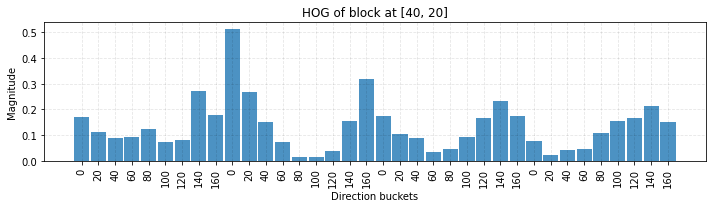

In [60]:
# Random location [200, 200] as an example.
loc_x = 20
loc_y = 40
ydata = get_magnitude_hist_block(loc_x, loc_y)
print('Temporary ydata is',ydata)
ydata = ydata / np.linalg.norm(ydata)
xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_y, loc_x))
plt.tight_layout()

In [58]:
ydata.shape

(36,)

In [53]:
#creating hog features 
#fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
#                    cells_per_block=(2, 2), visualize=True, multichannel=True)
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)

In [54]:
#creating hog features 
fd.shape

(16740,)

In [55]:
hog_image.shape

# Return：
# newarr : ndarray
# HOG for the image as a 1D (flattened) array.
# hog_image : ndarray (if visualise=True)
# A visualisation of the HOG image.

(256, 128)

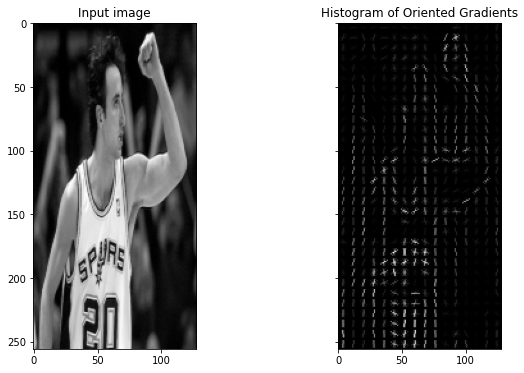

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

# 3. Image Segementations

The shape of img2 is (300, 400)
The shape of the first segmented image is (300, 400)
The shape of the second segmented image is (300, 400)


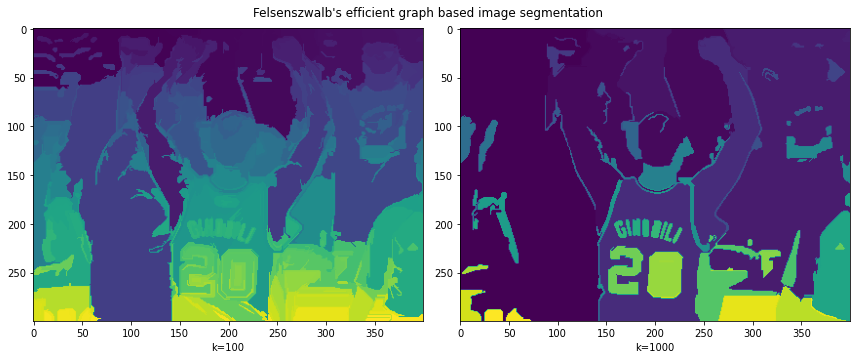

In [15]:
import skimage.segmentation
from matplotlib import pyplot as plt

img2 = imageio.imread("manu-2013.jpg", pilmode="L")
print('The shape of img2 is',img2.shape)
segment_mask1 = skimage.segmentation.felzenszwalb(img2, scale=100)
segment_mask2 = skimage.segmentation.felzenszwalb(img2, scale=1000)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print('The shape of the first segmented image is', segment_mask1.shape)
print('The shape of the second segmented image is', segment_mask2.shape)
ax1.imshow(segment_mask1); ax1.set_xlabel("k=100")
ax2.imshow(segment_mask2); ax2.set_xlabel("k=1000")

fig.suptitle("Felsenszwalb's efficient graph based image segmentation")
plt.tight_layout()
plt.show()